# Training

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Colab Notebooks/Numerical Experiment"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['One-dimensional Facebook.ipynb',
 'Processed and simulated data',
 'Original data',
 'Network results',
 '.ipynb_checkpoints',
 'include',
 'Assessment.ipynb',
 'Heston simulation-short.ipynb',
 'Training.ipynb',
 'Polynomial simulation-short.ipynb',
 'Training-huge_network.ipynb',
 'Assessment-new']

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.linalg as linalg

import math
import time
import random
import progressbar
from include import *

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

dtype = torch.FloatTensor

# 调整这些部分！！！！！ 还有调network_parameters

### Choice of model

In [3]:
choice = 'Heston'
LOG = False
append = '1-13-9-40-z'

### Parameters for neural network and simulation

In [4]:
#gradient penalty parameter
LAMBDA = 1
#related to sampling
BATCH_SIZE = 256

#iteration
CRITIC_ITERS = 5
ITERS = 500

DIM_M = 100
DIM_S = 200
DIM_D = 500

# sequential parameter
dt = 0.01/15
sub_iter = 15
vol = 0.1


## Load data

In this notebook, we cover all six choices of data, namely the 3-dimensional Heston model, the 3-dimensional polynomial model, the real data, and their respective log returns.

In [5]:
real_data = np.load('./Processed and simulated data/data_obs_'+choice+'.npy')

### Get parameters from data

In [6]:
[observes, n_obs, dim_s] = np.shape(real_data)
## unobserved dimension
if choice == 'real'or choice == 'real log':
    dim_z = 1
else:
    dim_z = 3
dim_x = dim_s+dim_z

## Networks and initialization

We do not define the initialization function elsewhere, because of the following reasons: (1) using nn.Module.apply, we apply initialization to the submodules instead of the modules, so $m$ stands for one single layer instead of the whole network architecture. (2) In this case, the positional argument for function "weights_init" can not be other than $m$, which stands for each submodule. Thus, the arguments "var" and "bias" has to be written inside the function. (3) We cannot modify "var" and "bias" too constantly if the weight initialization function needs to be imported. This is because when running "import utils" for a second time, python often neglects recent modifications to the library and automatically memorizes what it has imported earlier. 

In [8]:
def weights_init_mu(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.1)
        m.bias.data.fill_(1)
        
def weights_init_sigma(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.1)
        m.bias.data.fill_(1)
        
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.1)
        m.bias.data.fill_(3)
        

In [10]:
if LOG == True:
    dim_in_d = dim_s*(n_obs-1)
else:
    dim_in_d = dim_s*n_obs
    
# networks
netG_mu = Generator_mu(2,DIM_M,dim_x).type(dtype)
netG_sigma = Generator_sigma_big(4,DIM_S,dim_x).type(dtype)
netD = Discriminator(3,DIM_D,dim_in_d).type(dtype)

# initialization
netD.apply(weights_init_D)
netG_mu.apply(weights_init_mu)
netG_sigma.apply(weights_init_sigma)

Generator_sigma_big(
  (main): Sequential(
    (0): Linear(in_features=6, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): Linear(in_features=200, out_features=36, bias=True)
  )
)

## Set iteration steps

In [11]:
class Steps:
    def __init__(self,initial,final,iters):
        self.initial = initial
        self.final = final
        self.iters = iters

class AdamSteps(Steps):
    def __init__(self,initial,final,iters):
        '''for discriminator，write main_iters*critic_iters instead of iters'''
        super(AdamSteps,self).__init__(initial, final, iters)
        self.gamma = (final/initial)**(1/iters)

### Define learning rate

In [12]:
G_step = AdamSteps(1e-4, 1e-6, ITERS) #initial, final, iters
D_step = AdamSteps(1e-4, 1e-6, ITERS*CRITIC_ITERS)

optimizerD = optim.Adam(netD.parameters(), lr=D_step.initial, betas=(0.5, 0.9))
optimizerG_mu = optim.Adam(netG_mu.parameters(), lr=G_step.initial, betas=(0.5, 0.9))
optimizerG_sigma = optim.Adam(netG_sigma.parameters(), lr=G_step.initial, betas=(0.5, 0.9))

ELR = torch.optim.lr_scheduler.ExponentialLR

optimizerD_lrdecay = ELR(optimizerD, gamma=D_step.gamma, last_epoch=-1)
optimizerG_mu_lrdecay = ELR(optimizerG_mu, gamma=G_step.gamma, last_epoch=-1)
optimizerG_sigma_lrdecay = ELR(optimizerG_sigma, gamma=G_step.gamma, last_epoch=-1)

## Main iterations

### Data preparation

In [13]:
real_data_t = torch.Tensor(real_data).type(dtype)
real_St_iter = inf_train_iter(real_data_t, BATCH_SIZE)

### Main loop

In [15]:
for iteration in progressbar.progressbar(range(ITERS)):
    ############################
    # (1) Update D network
    ############################
    for p in netD.parameters():  # reset requires_grad
        p.requires_grad = True   # they are set to False below in netG update

    for iter_d in range(CRITIC_ITERS):
        # real count for getting condition
        real_St_batch = real_St_iter.__next__()
        real_St_batch_drop = real_St_batch[:,1:,:]
        
        #change the dimensions of data so that it can be fed to netD
        if LOG == True:
            real_St_batch_2d = real_St_batch_drop.view(BATCH_SIZE,-1)
        else:
            real_St_batch_2d = real_St_batch.view(BATCH_SIZE,-1)

        ## train with real
        D_real = netD(real_St_batch_2d)
        D_real = D_real.mean()

        ## train with fake
            
        #generate fake data without autograd
        with torch.no_grad(): # totally freeze netG
            init_val = initial_fake(dim_z, real_St_batch, vol)
            if LOG == True:
                fake_St_batch = simulate_return_big(init_val, netG_mu, netG_sigma, dt, dim_s, n_obs, sub_iter)
                fake_St_batch_drop = fake_St_batch[:,1:,:]
                fake_St_batch_2d = fake_St_batch_drop.view(BATCH_SIZE,-1)
            else:
                fake_St_batch = simulate_big(init_val, netG_mu, netG_sigma, dt, dim_s, n_obs, sub_iter)
                fake_St_batch_2d = fake_St_batch.view(BATCH_SIZE,-1)
            
        D_fake = netD(fake_St_batch_2d)
        D_fake = D_fake.mean()

        ## train with gradient penalty
        # use a new batch of data to penalize discriminator
        real_St_batch = real_St_iter.__next__()
        real_St_batch_drop = real_St_batch[:,1:,:]
        if LOG == True:
            real_St_batch_2d = real_St_batch_drop.view(BATCH_SIZE,-1)
        else:
            real_St_batch_2d = real_St_batch.view(BATCH_SIZE,-1)
        gradient_penalty = calc_gradient_penalty(netD, real_St_batch_2d, fake_St_batch_2d,LAMBDA)
        D_cost = D_fake - D_real + gradient_penalty 
        netD.zero_grad()
        D_cost.backward()
        optimizerD.step()
        optimizerD_lrdecay.step()
    ############################
    # (2) Update G network
    ###########################
    for p in netD.parameters():
        p.requires_grad = False  # to avoid computation
   
    init_val = initial_fake(dim_z, real_St_batch, vol)
    if LOG == True:
        fake_St_batch = simulate_return_big(init_val, netG_mu, netG_sigma, dt, dim_s, n_obs, sub_iter)
        fake_St_batch_drop = fake_St_batch[:,1:,:]
        fake_St_batch_2d = fake_St_batch_drop.view(BATCH_SIZE,-1)
    else:
        fake_St_batch = simulate_big(init_val, netG_mu, netG_sigma, dt, dim_s, n_obs, sub_iter)
        fake_St_batch_2d = fake_St_batch.view(BATCH_SIZE,-1)
    
    G = netD(fake_St_batch_2d)
    G = G.mean()
    G_cost = -G
    netG_mu.zero_grad()
    netG_sigma.zero_grad()
    G_cost.backward()
    optimizerG_mu.step()
    optimizerG_mu_lrdecay.step()
    optimizerG_sigma.step()
    optimizerG_sigma_lrdecay.step()

100% (500 of 500) |######################| Elapsed Time: 0:28:05 Time:  0:28:05


## Visualization of training

### transform tensors into numpy arrays

In [ ]:
fake_St = fake_St_batch.detach().numpy()
real_St = real_St_batch.detach().numpy()

### Plot

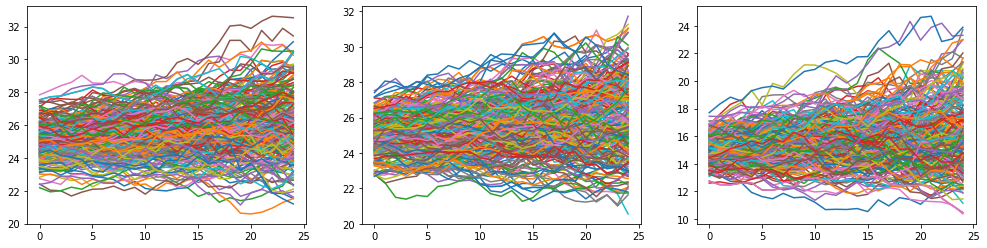

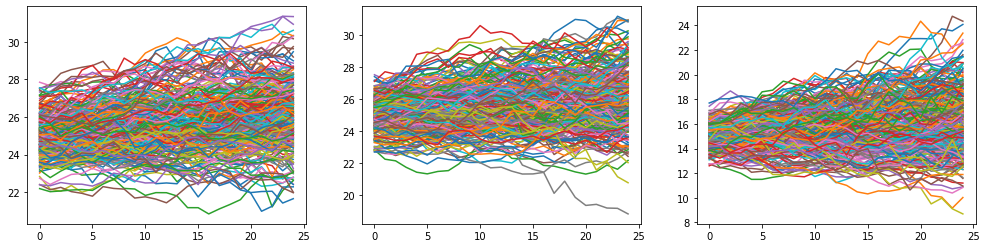

In [ ]:
visualize(choice,real_St)
visualize(choice,fake_St)

## Save data

### Network parameters

In [16]:
torch.save(netG_mu.state_dict(),'./Network results/netG_mu_'+choice+append+'.pt')
torch.save(netG_sigma.state_dict(),'./Network results/netG_sigma_'+choice+append+'.pt')

### Simulated data

In [ ]:
np.save('./Network results/data_gen_'+choice+append+'.npy',fake_St)